# Target: 

get m_bl *best pair* with *dR match*

considering the ttbar is a back to back event, the bl originate from the same top should have smaller angle


In [2]:
import sys, os
sys.path.append(os.path.abspath("/afs/desy.de/user/z/zhuxinyu/public/mass_reco/"))
import numpy as np
import ROOT
from ROOT import TCanvas, TLegend, TFile, TPaveLabel, TPaveText, TTree, TLorentzVector, TH1D, TVectorT, gStyle, THStack, gPad, TH2D
from ROOT import gROOT
import helper


In [2]:
# 1. get tfile
filename = "user.cgarvey.32744802._000002.output.root"
file = TFile(filename)
# 2. get ttree
nominal = file.Get("nominal")
truth = file.Get("truth")
print(nominal.GetEntries(), truth.GetEntries())

258576 4580000


In [3]:
m_bl_truth = TH1D ("m_bl ","invariant mass of bl pair by truth match" ,50 ,0 ,300)
m_bl_drmatch = TH1D ("m_bl_drmatch","invariant mass of bl pair by rmatch" ,50 ,0 ,300)

In [4]:
# reset the TH1 before starting fill, so that previous running of this cell won't affect the result
m_bl_truth.Reset()
m_bl_drmatch.Reset()

# truth match

In [5]:
nentry = 0
valid = 0
matched = 0
nominal.GetEntry(nentry)
nnumber = getattr(nominal, "eventNumber")
# for n in range(truth.GetEntries()):
for n in range(400000):
    truth.GetEntry(n)
    tnumber = getattr(truth, "eventNumber")
    if tnumber == nnumber:
        #####################################################
        ############# start analysis from here ##############
        #####################################################
        # construct p4 vector 
        ## truth level llbb
        p4s_truth_b = []
        p4s_truth_b.append(helper.p4_from_pt_eta_phi_m(truth, "MC_b_from_t"))
        p4s_truth_b.append(helper.p4_from_pt_eta_phi_m(truth, "MC_b_from_tbar"))
        # first element from t, second element from tbar
        ## lepton (el/mu/tau)
        prefixes = ['MC_Wdecay1_from_t', 'MC_Wdecay2_from_t', 'MC_Wdecay1_from_tbar','MC_Wdecay2_from_tbar']
        p4s_truth_lep = helper.get_leptons_from_truth(prefixes, truth)
        ## nominal level llbb (same as in minimax_lb.ipynb)
        p4s_lep = helper.GetLorenzP4List(nominal, 'lep')
        p4s_bjet = helper.GetLorenzP4List(nominal,'bjet')
        #------------------------------------------------------------------#

        # dR match p4 vector: p4s_lep vs p4s_truth_lep; p4s_bjet vs p4s_truth_b
        ## arrange the p4s as [from_b , from_bbar]
        if len(p4s_truth_lep)*len(p4s_lep)*len(p4s_truth_b)*len(p4s_bjet) == 0:
            nentry += 1
            nominal.GetEntry(nentry)
            nnumber = getattr(nominal, "eventNumber")
            continue
        
        p4s_match_lep = helper.deltaR_match(p4s_truth_lep, p4s_lep, 0.4)
        p4s_match_bjet = helper.deltaR_match(p4s_truth_b, p4s_bjet, 0.4)
        
        #------------------------------------------------------------------#
        # if one of the match failed, return a empty list []
        if len(p4s_match_lep)*len(p4s_match_bjet) != 0 :

            # draw the correct combination
            valid += 1 # for event that found the correct combination
            m1 = (p4s_match_lep[0] + p4s_match_bjet[0]).M()/1000
            m2 = (p4s_match_lep[1] + p4s_match_bjet[1]).M()/1000
            
            ## bl_dR_min pair
            if len(p4s_lep) ==2 and len(p4s_bjet) == 2:
                p4s_bjet_matched = helper.deltaR_match(p4s_lep, p4s_bjet, 100)
                if (len(p4s_bjet_matched)) != 2: 
                    nentry += 1
                    nominal.GetEntry(nentry)
                    nnumber = getattr(nominal, "eventNumber")
                    continue
                # draw the correct combination
                # fill hist
                m_bl_drmatch.Fill((p4s_lep[0]+p4s_bjet_matched[0]).M()/1000)
                m_bl_drmatch.Fill((p4s_lep[1]+p4s_bjet_matched[1]).M()/1000)
                m_bl_truth.Fill(m1)
                m_bl_truth.Fill(m2)

                # check if is correct:
                for k in [0, 1]:
                    dR1 = ROOT.Math.VectorUtil.DeltaR(p4s_lep[0],p4s_match_lep[k])
                    dR2 = ROOT.Math.VectorUtil.DeltaR(p4s_bjet_matched[0],p4s_match_bjet[k])
                    if dR1 < 0.00001 and dR2 < 0.00001:
                        matched += 1
                        break




        #####################################################
        ############# end analysis from here ################
        #####################################################
        nentry += 1
        nominal.GetEntry(nentry)
        nnumber = getattr(nominal, "eventNumber")
        
print("total event: ", nentry, ", matched event: ", valid, ", correct:", matched)


total event:  22962 , matched event:  18351 , correct: 9730


24038.0 24050.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


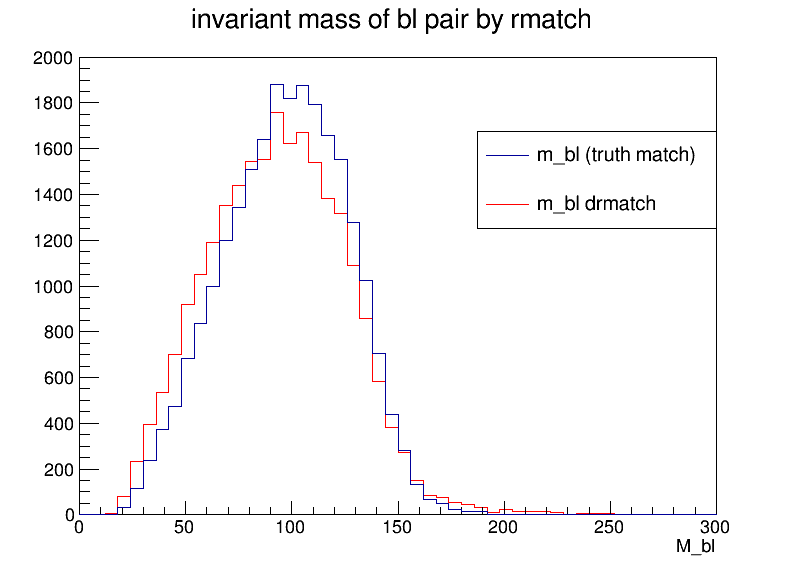

In [9]:
c1 = TCanvas('c1', 'canvas1', 0, 0, 800, 600 )

m_bl_drmatch.SetLineColorAlpha(2, 1)
m_bl_drmatch.Draw()
m_bl_drmatch.GetXaxis().SetTitle("M_bl")
m_bl_drmatch.SetMaximum(2000)
m_bl_truth.Draw('same')

leg = TLegend(0.6,0.6,0.9,0.77)
leg.AddEntry(m_bl_truth,"m_bl (truth match)", "l")
leg.AddEntry(m_bl_drmatch,"m_bl drmatch", "l")
leg.Draw()

c1.Draw()

print(m_bl_drmatch.GetEntries(), m_bl_truth.GetEntries())

# analysis events

In [13]:
# for n in range(nominal.GetEntries()):
for n in range(10):
    nominal.GetEntry(n)
    p4s_lep = helper.GetLorenzP4List(nominal,'lep')
    p4s_bjet = helper.GetLorenzP4List(nominal,'bjet')
    if len(p4s_lep) != 2 or len(p4s_bjet) != 2: continue
    
    # match the l & b
    p4s_bjet_matched = helper.deltaR_match(p4s_lep, p4s_bjet, 100)
    if (len(p4s_bjet_matched)) != 2: continue
    # print(n, ROOT.Math.VectorUtil.DeltaR(p4s_lep[0], p4s_bjet_matched[0]), ROOT.Math.VectorUtil.DeltaR(p4s_lep[1], p4s_bjet_matched[1]))
    m_bl_truth.Fill((p4s_lep[0]+p4s_bjet_matched[0]).M()/1000)
    m_bl_truth.Fill((p4s_lep[1]+p4s_bjet_matched[1]).M()/1000)
    print(ROOT.Math.VectorUtil.DeltaR(p4s_lep[0], p4s_bjet[0])," , ", ROOT.Math.VectorUtil.DeltaR(p4s_lep[0], p4s_bjet[1]))
    print(ROOT.Math.VectorUtil.DeltaR(p4s_lep[0], p4s_bjet_matched[0]))


3.5533016566229727  ,  1.2962476288192613
1.2962476288192613
3.881414546524842  ,  1.003948767543548
1.003948767543548
0.8361137770591017  ,  2.1077962163347954
0.8361137770591017
0.700519569845148  ,  2.664717204477434
0.700519569845148
2.580223141312856  ,  0.5823628130590897
0.5823628130590897
3.049261856770565  ,  1.988635392129713
1.988635392129713


# plot

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


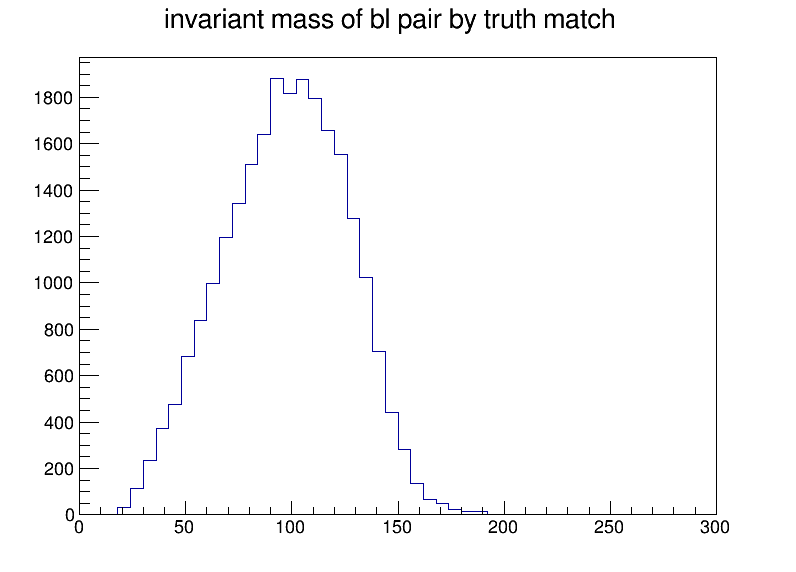

In [8]:
c1 = TCanvas('c1', 'canvas1', 0, 0, 800, 600 )
gStyle.SetOptStat(0)
m_bl_truth.Draw()
c1.Draw()